# **\[SOLAR_A\]** TGCN

JiyunLim  
2023-08-20

# 2023.08.15 러너 수정

> **변경사항** : RGCN_Learner 수정 - 일부기능추가

> **포인트** : 배치학습을 적용하여 update가 빨리 이루어지도록 코드 수정.

<figure class="margin-caption">
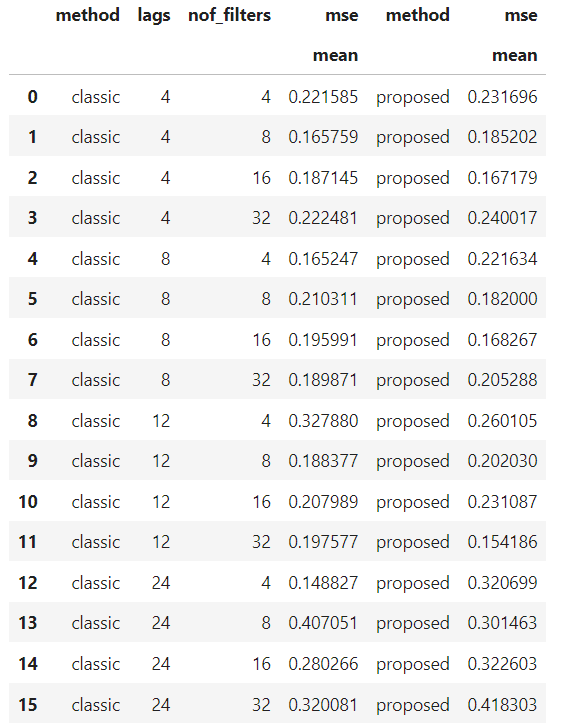
<figcaption aria-hidden="true">0815기준 변경된 러너로 시뮬레이션 한
결과.</figcaption>
</figure>

In [59]:
# modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pytorch geometric temporal
import torch_geometric_temporal
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import TGCN

# torch
import torch
import torch.nn.functional as F


# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        edge_weights = np.array(self._dataset["weights"]).T
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset
    

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

class RGCN_Learner:
    def __init__(self):
        self.method = 'RecurrentGCN'
        self.figs = []
        self.epochs = 0
        self.losses = []
        self._node_idx = 0
    def load(self,y): 
        if (self.lags is None) or (self.train_ratio is None):
            self.lags = 2 
            self.train_ratio = 0.8 
        self.t,self.n = y.shape
        dct = makedict(FX=y.tolist())
        self.loader = Loader(dct)
        self.dataset = self.loader.get_dataset(lags=self.lags)
        self.X = torch.tensor(self.dataset.features).float()
        self.y = torch.tensor(self.dataset.targets).float()
        self.train_dataset, self.test_dataset = temporal_signal_split(self.dataset, train_ratio = self.train_ratio)
        self.len_test = self.test_dataset.snapshot_count
        self.len_tr = self.train_dataset.snapshot_count
    def get_batches(self, batch_size=256):
        num_batches =  self.len_tr // batch_size + (1 if self.len_tr % batch_size != 0 else 0)
        self.batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            self.batches.append(self.train_dataset[start_idx:end_idx])
    
    def learn(self,epoch=1):
        self.model.train()
        for e in range(epoch):
            losses_batch = []
            for b,batch in enumerate(self.batches):
                loss = 0
                self.hidden_state = None
                for t, snapshot in enumerate(batch):
                    snapshot = snapshot.to(device)
                    yt_hat, self.hidden_state = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.hidden_state)
                    loss = loss + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                    print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
                loss = loss / (t+1)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses_batch.append(loss.item())
            self.epochs = self.epochs + 1
            print(f'\repoch={self.epochs}\t loss={np.mean(losses_batch)}\n', end='', flush=True)
        self.losses.append(np.mean(losses_batch))
        self._savefigs() 
    def _savefigs(self): 
        self.__call__()
        self._node_idx
        with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(self.y[:,self._node_idx],label='real',lw=0.5)
            ax.plot(self.yhat[:,self._node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={self.epochs}, node_idx={self._node_idx}',size=15)
            ax.legend()
        self.figs.append(fig)
        plt.close()
    def __call__(self,dataset=None):
        if dataset == None: 
            dataset = self.dataset
        self.yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.hidden_state)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':self.X, 'y':self.y, 'yhat':self.yhat} 
    

def rslt_plot(y, yhat, t_, node_idx):
    with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(y[:t_,node_idx],label='real',lw=0.5)
            ax.plot(yhat[:t_,node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={lrnr.epochs}, node_idx={node_idx}',size=15)
            ax.legend()

In [60]:
class T_GCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(T_GCN, self).__init__()
        self.recurrent = TGCN(node_features, filters)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, prev_hidden_state):
        h = self.recurrent(x, edge_index, edge_weight, prev_hidden_state)
        y = F.relu(h)
        y = self.linear(y)
        return y, h

## Load data

In [61]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)

t = df.loc[:,'date']
regions = list(df.loc[:, 'Bukchoncheon':'Gyeongju-si'].columns)

In [62]:
# global parameters
TRAIN_RATIO = 0.8
T, N = len(t), len(regions)
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

## sample codes

In [63]:
FILTERS_ = 16
LAGS_ = 24

`-` classical

In [64]:
# y를 학습
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = LAGS_
lrnr.train_ratio = 0.8
lrnr.load(y) 
# step3: construct networks 
lrnr.nof_filters = FILTERS_
lrnr.model = T_GCN(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=128)

In [65]:
for e in range(5):
    lrnr.learn()

epoch=1  loss=0.7148760259151459590522766   
epoch=2  loss=0.3372065853327513798202515   
epoch=3  loss=0.275450338609516672881317        
epoch=4  loss=0.2340098479762673466776276   
epoch=5  loss=0.2061961470171809295466614   

In [69]:
for e in range(5):
    lrnr.learn()

epoch=6  loss=0.1953198434785008426493073   
epoch=7  loss=0.1879891343414783583748627   
epoch=8  loss=0.18516917247325182292099 9   
epoch=9  loss=0.182824434712529184991684        
epoch=10     loss=0.181836865842342389750366    

In [70]:
yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yhat[yhat<0] = 0

In [71]:
np.mean((y-yhat)[LEN_TR:,:]**2)

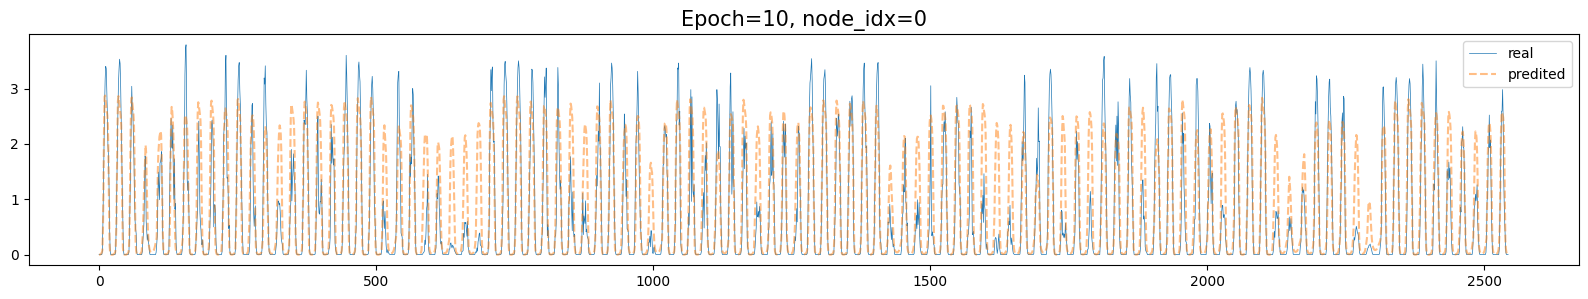

In [72]:
lrnr.figs[-1]

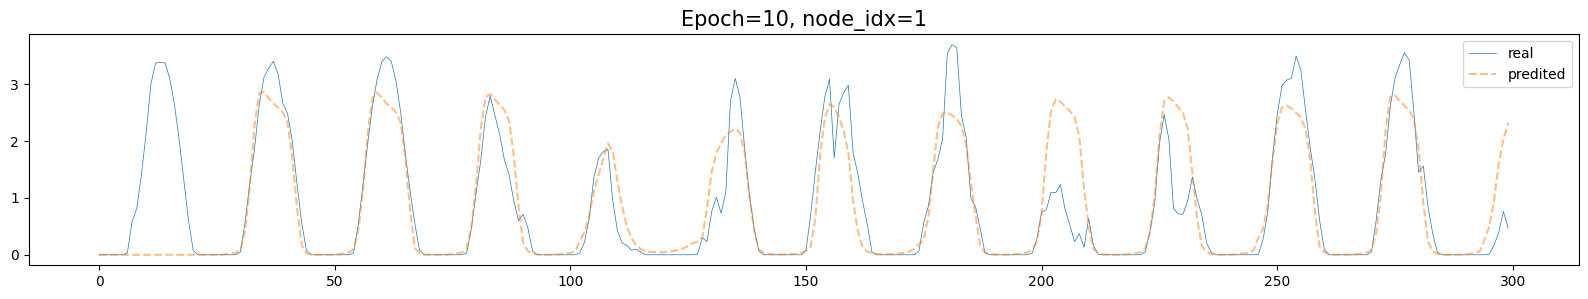

In [73]:
rslt_plot(y, yhat, 300, 1)

`-` proposed

이건 필터를 아예 고정시켜야 할듯.

In [199]:
# yU를 학습
# step1: create lrnr object
lrnr1 = RGCN_Learner()
# step2: load data 
lrnr1.lags = 4
lrnr1.train_ratio = 0.8
lrnr1.load(yU) 
# step3: construct networks 
lrnr1.nof_filters = 16
lrnr1.model = T_GCN(node_features=lrnr1.lags, filters=lrnr1.nof_filters).to(device)
lrnr1.optimizer = torch.optim.Adam(lrnr1.model.parameters(),lr=10/1000)
# step4: learn 
lrnr1.get_batches(batch_size=24)

In [200]:
for e in range(5):
    lrnr1.learn()

epoch=1  loss=1.973544025490450486820984    
epoch=2  loss=0.5588666770693868506546          
epoch=3  loss=0.43626026202772943171234     
epoch=4  loss=0.28179422939239546115158     
epoch=5  loss=0.273898660616819237413788        

In [195]:
for e in range(5):
    lrnr1.learn()

epoch=6  loss=0.273843227517466235342407        
epoch=7  loss=0.267529814958918936108398        
epoch=8  loss=0.264783278410864487815857        
epoch=9  loss=0.26252196209375255331192         
epoch=10     loss=0.2608693204386982627295          

In [196]:
yUhat = np.concatenate([np.array([list(lrnr1.yhat[0])]*lrnr1.lags),lrnr1.yhat],axis=0)
yU_mse = np.mean((yU - yUhat)**2)
yU_mse

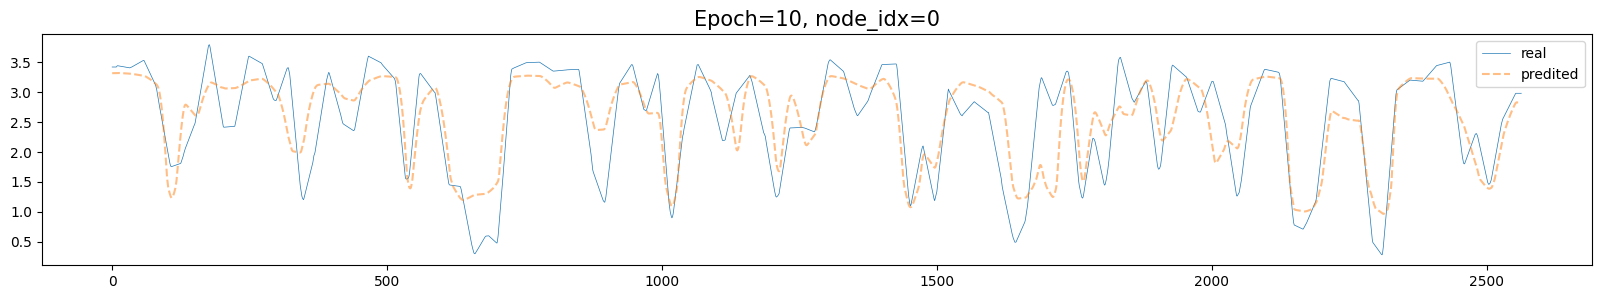

In [197]:
lrnr1.figs[-1]

In [173]:
# yP를 학습
# step1: create lrnr object
lrnr2 = RGCN_Learner()
# step2: load data 
lrnr2.lags = 24
lrnr2.train_ratio = 0.8
lrnr2.load(yP) 
# step3: construct networks 
lrnr2.nof_filters = 16
lrnr2.model = T_GCN(node_features=lrnr2.lags, filters=lrnr2.nof_filters).to(device)
lrnr2.optimizer = torch.optim.Adam(lrnr2.model.parameters(),lr=10/1000)
# step4: learn 
lrnr2.get_batches(batch_size=128)

In [174]:
for e in range(5):
    lrnr2.learn()

epoch=1  loss=0.0640248865820467522239971       
epoch=2  loss=0.0210324639920145275511875       
epoch=3  loss=0.0180686870007775720713253       
epoch=4  loss=0.01744923490332439517931366  
epoch=5  loss=0.01706365210702642869142914  

In [178]:
for e in range(5):
    lrnr2.learn()

epoch=6  loss=0.01691564306383952559932327  
epoch=7  loss=0.01685872767120599733736038  
epoch=8  loss=0.0167353707365691661366272       
epoch=9  loss=0.01659254234982654582018852  
epoch=10     loss=0.016481298953294754042446        

In [179]:
yPhat = np.concatenate([np.array([list(lrnr2.yhat[0])]*lrnr2.lags),lrnr2.yhat],axis=0)
yPhat[yPhat<0] = 0
yP_mse = np.mean((yP - yPhat)**2)
yP_mse

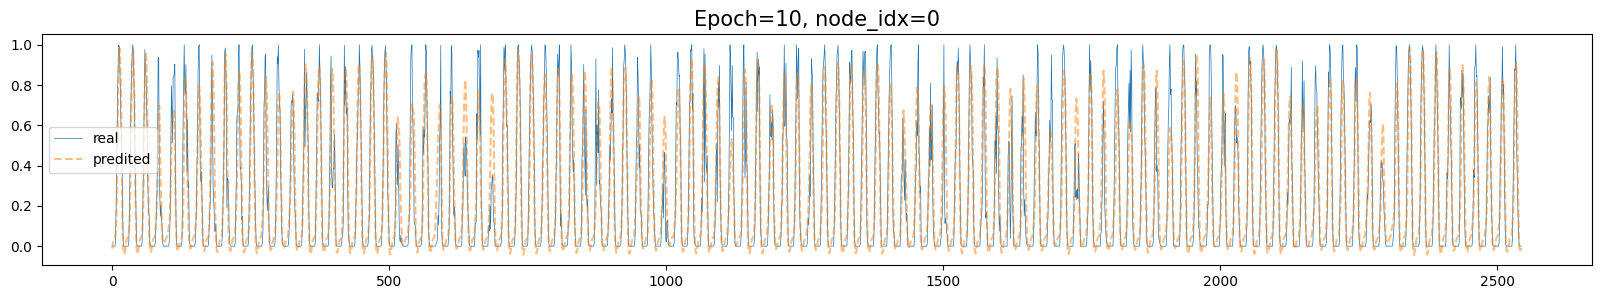

In [180]:
lrnr2.figs[-1]

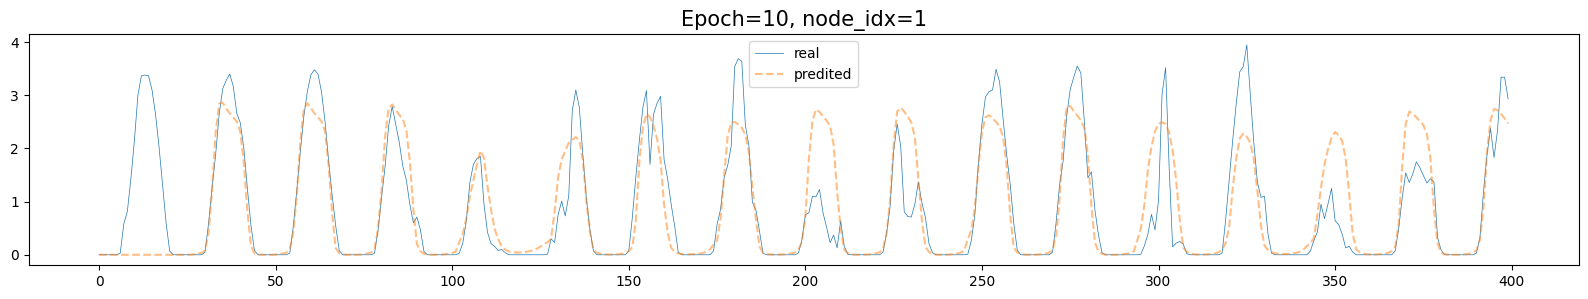

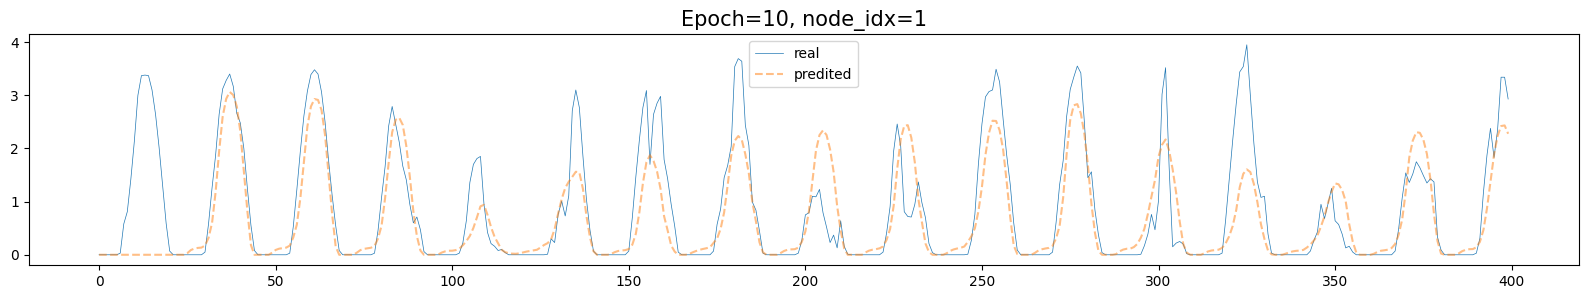

In [184]:
rslt_plot(y, yhat, 400, 1)
rslt_plot(y, yUhat*yPhat, 400, 1)

`-` result

In [198]:
classic = ((y - yhat)[LEN_TR:,:]**2).mean()
proposed = ((y - yUhat*yPhat)[LEN_TR:,:]**2).mean()
print('classic(mse)', round(classic,4))
print('proposed(mse)', round(proposed,4))

classic(mse) 0.2508
proposed(mse) 0.1394

## 결과 (lags=4)

In [ ]:
# result_columns = ['model', 'lags', 'filters', 'epoch', 'classic(mse)', 'proposed(mse)']
# rslt_df = pd.DataFrame(columns=result_columns)
# rslt_df

In [42]:
# new_rslt = pd.DataFrame({'model':['TGCN'],'lags':[lrnr.lags],'filters':[lrnr.nof_filters],'epoch':[lrnr.epochs],'classic(mse)': [round(classic, 4)], 'proposed(mse)': [round(proposed, 4)],'yU(mse)':[round(yU_mse,4)], 'yP(mse)':[round(yP_mse,4)]})
# rslt_df = pd.concat([rslt_df, new_rslt], ignore_index=True)
# rslt_df

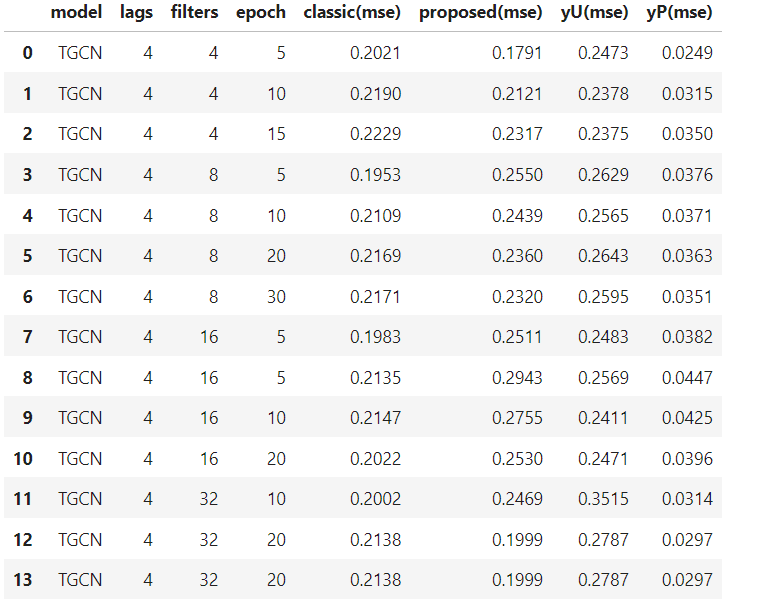

## Edit rgcn

In [43]:
# learn 
def rgcn(FX, model, train_ratio, lags, filters, epoch):
    # step1: create lrnr object
    lrnr = RGCN_Learner()
    # step2: load data
    lrnr.lags = lags
    lrnr.train_ratio = train_ratio
    lrnr.load(FX)
    # step3: construct networks
    lrnr.nof_filters = filters
    lrnr.model = model(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
    lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(), lr=10/1000)
    # step4: learn
    lrnr.get_batches(batch_size=24*2)
    for e in range(epoch):
        lrnr.learn()
    yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
    return yhat

In [44]:
# hyper params
LAGS = 8
FILTERS = 16
EPOCH = 10

`-` classic

In [45]:
yhat = rgcn(y, T_GCN, train_ratio = TRAIN_RATIO, lags=LAGS, filters = FILTERS, epoch=EPOCH)
yhat[yhat<0] = 0

epoch=1  loss=0.634734219243360243022156    
epoch=2  loss=0.214290097355842627552795    
epoch=3  loss=0.18899562954902657034912     
epoch=4  loss=0.184996856333211423660583    
epoch=5  loss=0.183563500989315127438965        
epoch=6  loss=0.182166401903296640789795    
epoch=7  loss=0.181114748813385187580566        
epoch=8  loss=0.18061342592849297015381     
epoch=9  loss=0.18026739722767549738159     
epoch=10     loss=0.1798526778124099683539      

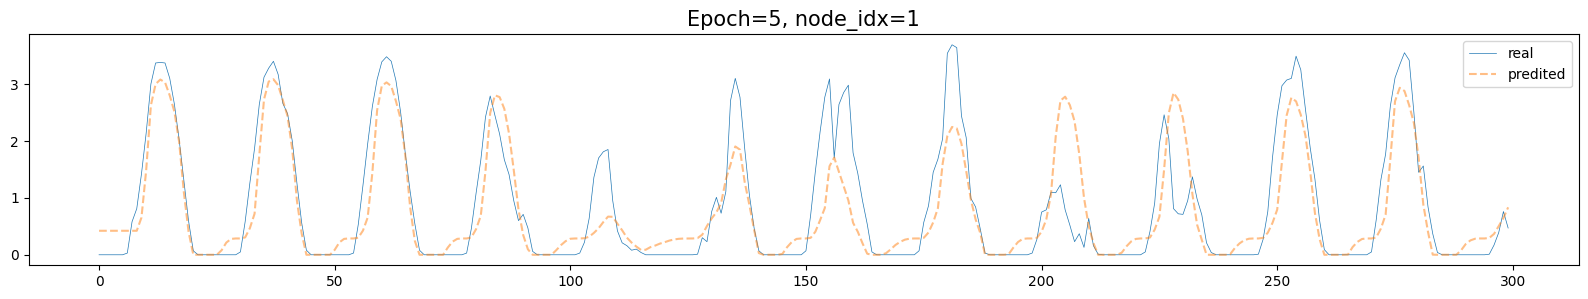

In [46]:
rslt_plot(y, yhat, 300, 1)

In [47]:
np.mean((y-yhat)[LEN_TR:,:]**2)

`-` proposed

In [49]:
# 방법2 
yUhat = rgcn(yU, T_GCN, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)

yPhat = rgcn(yP, T_GCN, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
yPhat[yPhat < 0] =0 

classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

epoch=1  loss=2.333493923032006683514404    
epoch=2  loss=0.58906636612359864850464     
epoch=3  loss=0.5671903951916584973999          
epoch=4  loss=0.52818218220111933247833     
epoch=5  loss=0.43731502564840543528595     
epoch=6  loss=0.324232375725757257909546    
epoch=7  loss=0.283141995931780630284424    
epoch=8  loss=0.27344090803418059131012     
epoch=9  loss=0.270585637106451945906067    
epoch=10     loss=0.2736738329363424660095      
epoch=1  loss=0.068043883326788283362236        
epoch=2  loss=0.0179809645078209963197823   
epoch=3  loss=0.0171755659935432834868126   
epoch=4  loss=0.0166860722698444566234207   
epoch=5  loss=0.0162947421330352167586823       
epoch=6  loss=0.0161438728032936939982224   
epoch=7  loss=0.0160114510569634825875168       
epoch=8  loss=0.0159277335069207274944763       
epoch=9  loss=0.0158768884707675492066193       
epoch=10     loss=0.01584194766270906342266         

total_mse(classic): 0.1991
total_mse(proposed): 0.1772


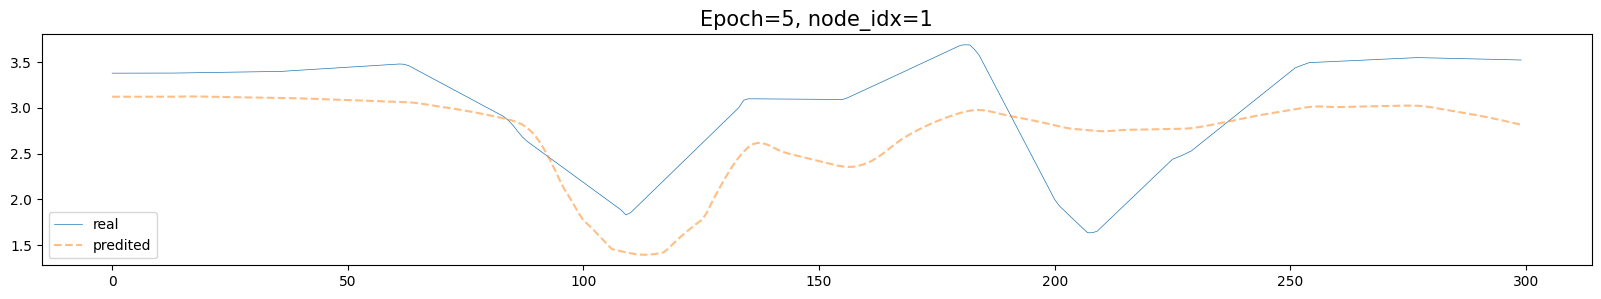

In [50]:
rslt_plot(yU, yUhat, 300, 1)

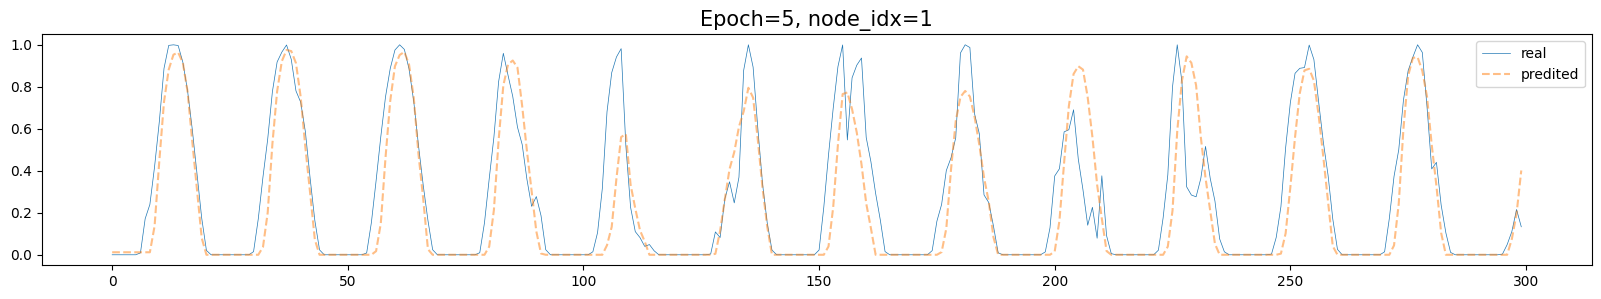

In [51]:
rslt_plot(yP, yPhat, 300, 1)

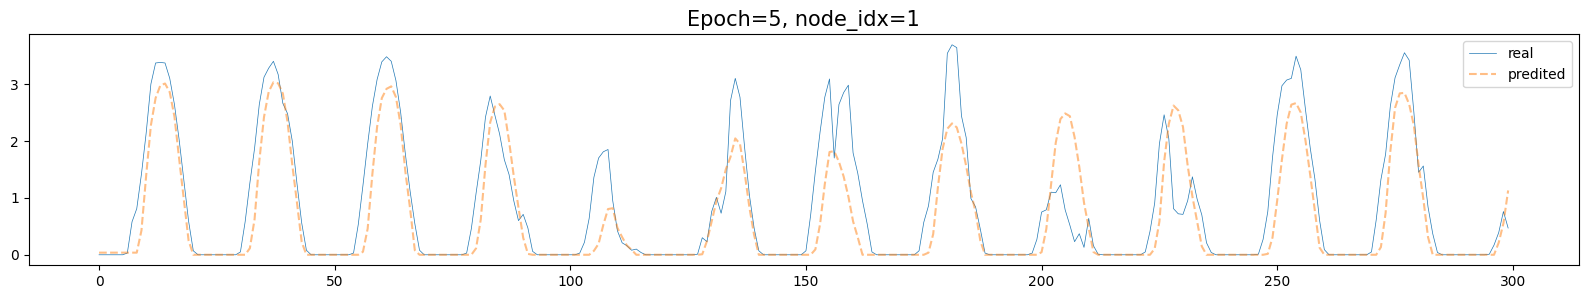

In [52]:
rslt_plot(y, yUhat*yPhat, 300, 1)

## simul code

In [26]:
# for simulation
import itertools
import time
import datetime

class Simulator:
    def __init__(self):
        self.col = ['model', 'method', 'lags', 
       'nof_filters', 'epoch', 'calculation_time',
       'index_time',
       'node', 'mse']
        self.df = pd.DataFrame(columns=self.col)
        self.data = pd.read_csv('data_eng_230710.csv')
    
    def simulate(self,n_iteration,lags,filters,epoch,Model):

        # make y, y_upper, y_period, time, regions 
        y = self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
        yU = self.data.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
        yP = np.divide(y, yU+1e-10)
        t = self.data.loc[:,'date']
        regions = list(self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)
        
        TRAIN_RATIO = 0.8
        T,N = len(t),len(regions) 
        LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
        LEN_TR = T - LEN_TEST        
        
        self.n_iteration = n_iteration
        self.method = ['classic','proposed']
        self.lags = lags
        self.filters = filters
        self.epoch = epoch
        self.Model = Model
        model_name= Model.__name__.replace('_','')

        for iteration in range(n_iteration):
            for m,l,f,e in itertools.product(self.method, self.lags, self.filters, self.epoch):
                if m == 'classic':
                    t1 = time.time()
                    yhat = rgcn(y, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e)
                    yhat[yhat < 0]= 0   
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                else: # proposed 
                    t1 = time.time()
                    yUhat = rgcn(yU, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e)
                    yPhat = rgcn(yP, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e)
                    yPhat[yPhat < 0] =0 
                    yhat = yUhat*yPhat
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                print("method:{} lag:{} filters:{} epoch:{} is done".format(m,l,f,e))        
            self.df.to_csv("./results/test/T_GCN/before/SOLAR_{}.csv".format(str(pd.to_datetime(datetime.datetime.now())) + str('_') + model_name.lower()),index=False)
            print("save results")

`-` test1

In [27]:
s1 = Simulator()

In [ ]:
s1.simulate(
    n_iteration = 1,
    lags = [4, 8, 12, 24],
    filters = [4, 8, 16, 32],
    epoch = [10],
    Model = T_GCN
)

epoch=1  loss=0.91663168474685323340149     
epoch=2  loss=0.456394004267315594111633    
epoch=3  loss=0.306352132281591758977356    
epoch=4  loss=0.243445452216059657254333    
epoch=5  loss=0.212900458033694784045715    
epoch=6  loss=0.19787148594163184195038         
epoch=7  loss=0.18978629538486173733673         
epoch=8  loss=0.184825292853421953582153        
epoch=9  loss=0.18193799898374913202545         
epoch=10     loss=0.180308003585005933089   5       
method:classic lag:4 filters:4 epoch:10 is done
epoch=1  loss=0.65466921170090528950043     
epoch=2  loss=0.24006356091000314387665     
epoch=3  loss=0.197198889976324044624023    
epoch=4  loss=0.18387587905623193944885         
epoch=5  loss=0.17905731932368398972473         
epoch=6  loss=0.17759420306876647737335         
epoch=7  loss=0.17654559328112496748352         
epoch=8  loss=0.17584933479164921047302         
epoch=9  loss=0.175770469876222831385803        
epoch=7  loss=0.17497854263976562791321         


In [54]:
import os
fnames = ['./results/test/T_GCN/before/'+l for l in os.listdir('./results/test/T_GCN/before/') if l[0] != '.']
fnames 

In [55]:
df = pd.concat([pd.read_csv(fname) for fname in fnames]).reset_index(drop=True)
df.head()

In [57]:
def summary_table(df):
    df_summary = df.groupby(by=['method', 'lags','nof_filters']).agg({'mse':[np.mean]}).reset_index()
    df_classic = df_summary[df_summary['method']=='classic']
    df_proposed = df_summary[df_summary['method']=='proposed'].reset_index()[['method','mse']]
    df_compare = pd.concat([df_classic, df_proposed], axis=1)
    return df_compare

In [58]:
# df.groupby(by=['method', 'lags','nof_filters']).agg({'mse':[np.mean]})
summary_table(df)

# 2023.08.24 일부 수정